# Combatting Partisan Homogenization in New Content Recommenders - Baselines(Tf-Idf)

In [1]:
# to do
# test with our prototypes and our actual topic labelled data
# use immigration and guns topic, prototypes have to have differing stance variation

## Table of Contents 
### [Clustering Documents, Filtering and Vectorization](#Clustering_Documents_Filtering_Vectorization)
### [Baseline 1 - (Cluster Similarity vs Model Performance)](#Cluster_Similarity_vs_Model_Performance)
### [Baseline 2 - (Online Setting Performance)](#Online_Setting_Performance)
### [Baseline 3 - (Single Cluster Online Setting Performance)](#Single_Cluster_Online_Setting_Performance)
### [Baseline 4 - (Regularization vs Online Setting Performance)](#Regularization_vs_Online_Setting_Performance)
### [Baseline 5 - (Learning Rate vs Online Setting Performance)](#Learning_Rate_vs_Online_Setting_Performance)
### [Baseline 6 - (Online Setting Mixed Data Performance)](#Online_Setting_Mixed_Data_Performance)
### [Baseline 7 - (Learning Rate vs Online Setting Mixed Data Performance)](#Learning_Rate_vs_Online_Setting_Mixed_Data_Performance)

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [89]:
from general_utils import timer

from config import RANDOM_SEED

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from metrics_utils import calculate_avg_precision, calculate_map, get_scores, get_scores_wot, calculate_avg_precision_param_variation, calculate_map_param_variation

from model_utils import ( run_model, 
                         run_bs1_train_all, 
                         run_online_setting_active, 
                         run_bs2_train_all, 
                         run_bs3_train_all, 
                         run_bs4_train_all, 
                         run_bs5_train_all, 
                         run_bs6_train_all, 
                         run_bs7_train_all)

from plotters_baseline import ( plot_size_dist, 
                               bsl1_sim_vs_score_all_users, 
                               regularization_plot_helper, 
                               plot_regularization_vs_metrics_at_k, 
                               combine_scores_reg_vs_metrics_at_k, 
                               plot_regularization_vs_metrics_at_k_cumu, 
                               plot_lr_vs_metrics_at_k, 
                               plot_lr_vs_metrics_at_k_cumu, 
                               plot_online_setting_per_clusterpair, 
                               plot_helper_all_cp, 
                               plot_all_cp_online, 
                               plot_all_cp_singlecluster, 
                               plot_helper_scp, 
                               plot_single_cluster_performance, 
                               plot_mixed_data_all_cp_perf, 
                               plot_helper_md, 
                               plot_prec_sep, 
                               plot_mixed_data_performance_per_cluster, 
                               plot_mixed_data_performance, 
                               combine_scores_cumu_online_setting,
                               plot_mixed_cluster_cumulative, 
                               plot_online_learning_cumulative, 
                               plot_single_cluster_cumulative, 
                               plot_mixed_data_all_cp_perf, 
                               lr_mixed_plot_helper, 
                               plot_lr_vs_metrics_at_k_mixed, 
                               plot_mixed_data_all_cp_precis_lr, 
                               plot_mixed_cluster_cumulative_per_cluster  )   

In [5]:
warnings.filterwarnings('ignore')

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

## Clustering Documents, Filtering and Vectorization <a class="anchor" id="Clustering_Documents_Filtering_Vectorization"></a>

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4386 mins


Finished running 'sample_data' in 0.0018 mins

Sampled Size: 100000
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3202 mins

vocab_size : 16829

Finished running 'tfidf_vectorization' in 0.1601 mins


Shape Before DIM REDUC : (100000, 16829)
Shape After DIM REDUC : (100000, 16829)

Finished running 'dimensionality_reduction' in 0.8789 mins


Running KMEANS Clustering with k=1000

Finished running 'run_clustering' in 0.1965 mins


Finished running

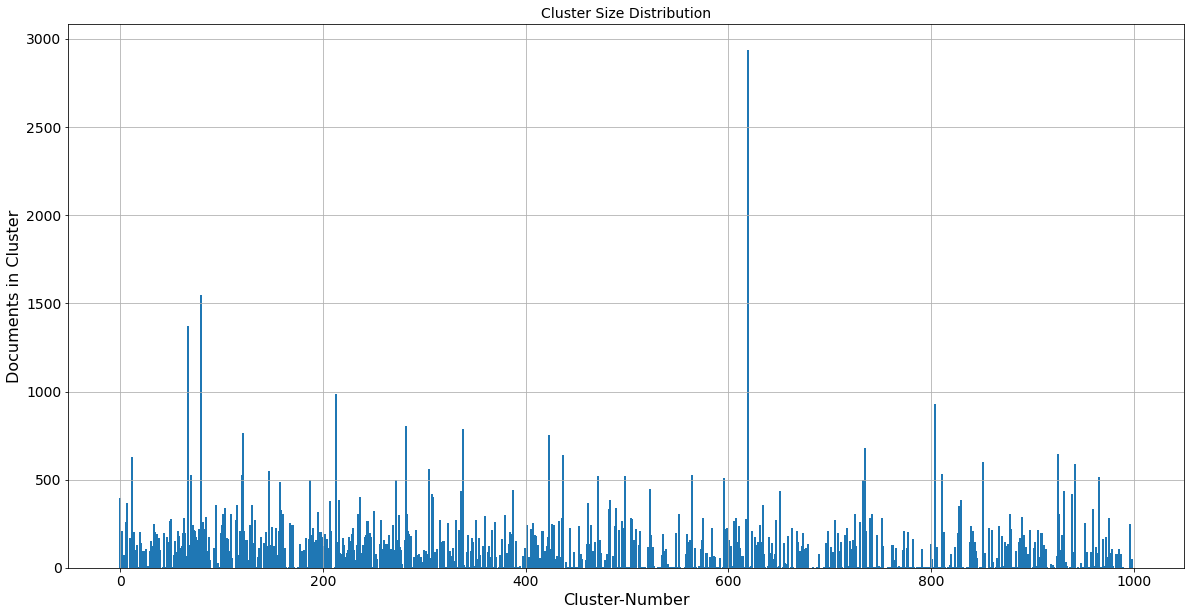


Finished running 'get_pairwise_dist' in 0.0001 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0017 mins

499500


In [7]:
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

vectors,vocab,tfidf_vectorizer = tfidf_vectorization(df=sampled_df,min_df=50,max_df=0.75,seed=RANDOM_SEED)

reduced_vectors = dimensionality_reduction(vectors=vectors,mode="SVD_LSA",dim=500,seed=RANDOM_SEED)

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

In [8]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0003 mins



In [9]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=450,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.0662 mins

Filtered CLustered Pairs : 55


In [10]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0000 mins



## Baseline 1 : <a class="anchor" id="Cluster_Similarity_vs_Model_Performance"></a>

In [11]:
df_result = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.0076 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.0065 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0081 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0067 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0057 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.0088 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.0047 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.0085 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.0080 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0098 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.0051 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.0070 mins

Training model

In [12]:
df_result_homog = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.0086 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.0069 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0079 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0062 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0054 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.0067 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.0065 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.0072 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.0063 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0089 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.0059 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.0065 mins

Training model

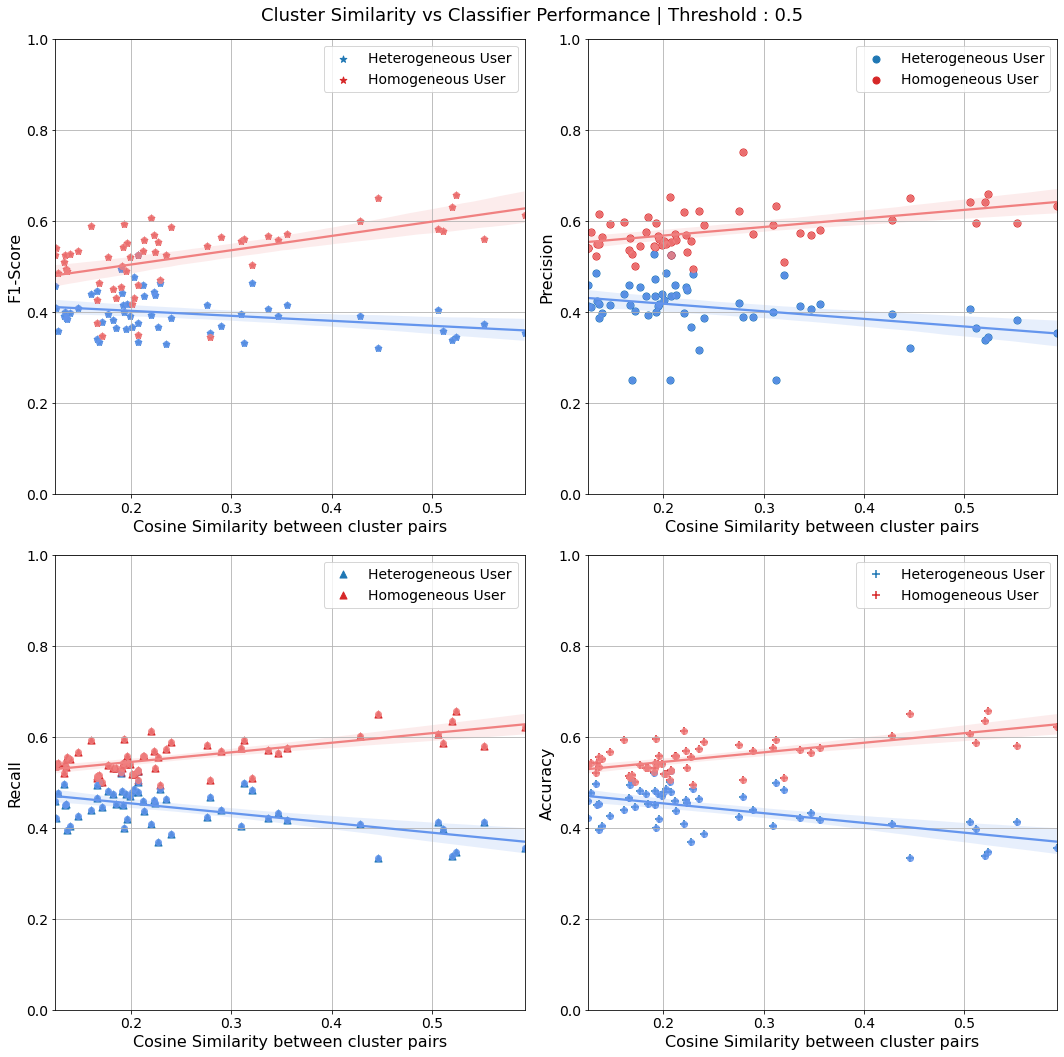


Finished running 'bsl1_sim_vs_score_all_users' in 0.0192 mins



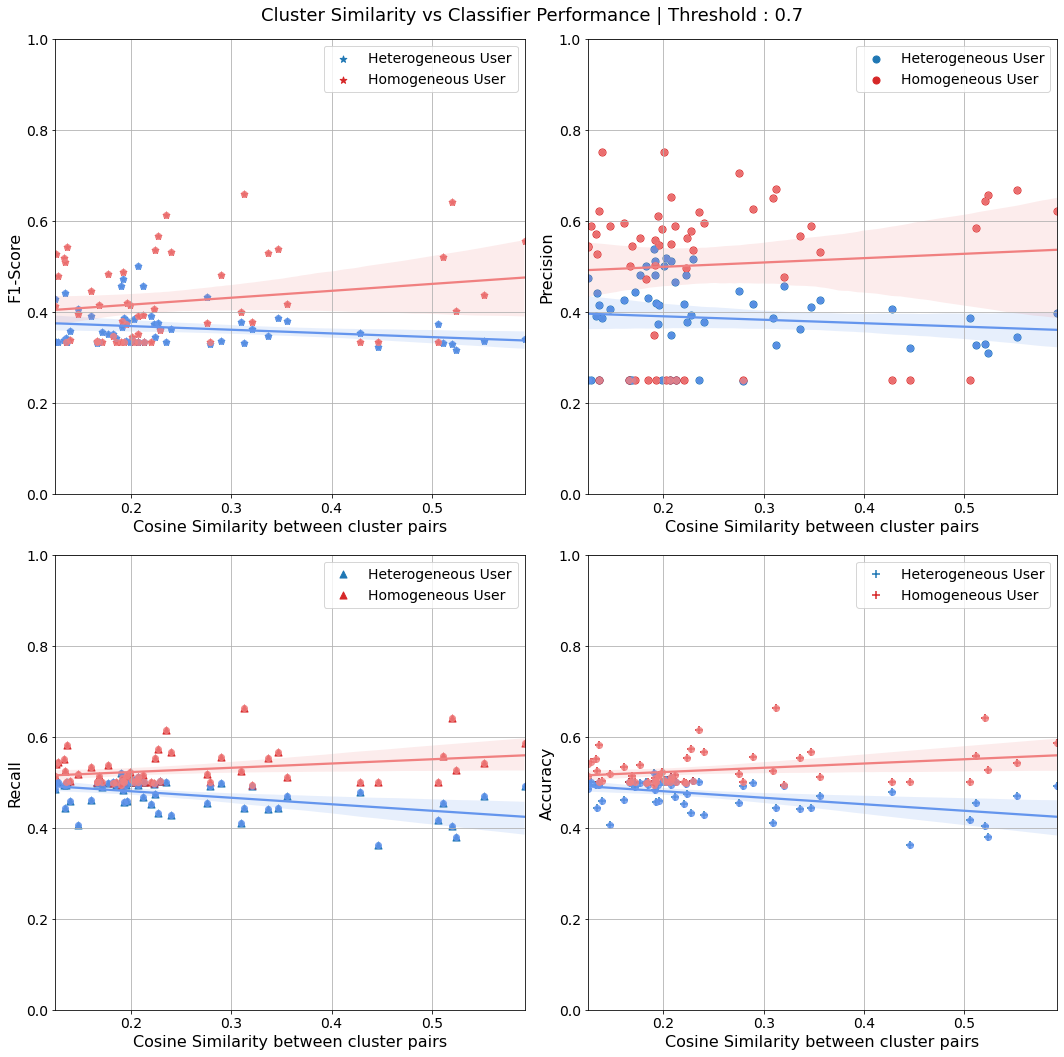


Finished running 'bsl1_sim_vs_score_all_users' in 0.0195 mins



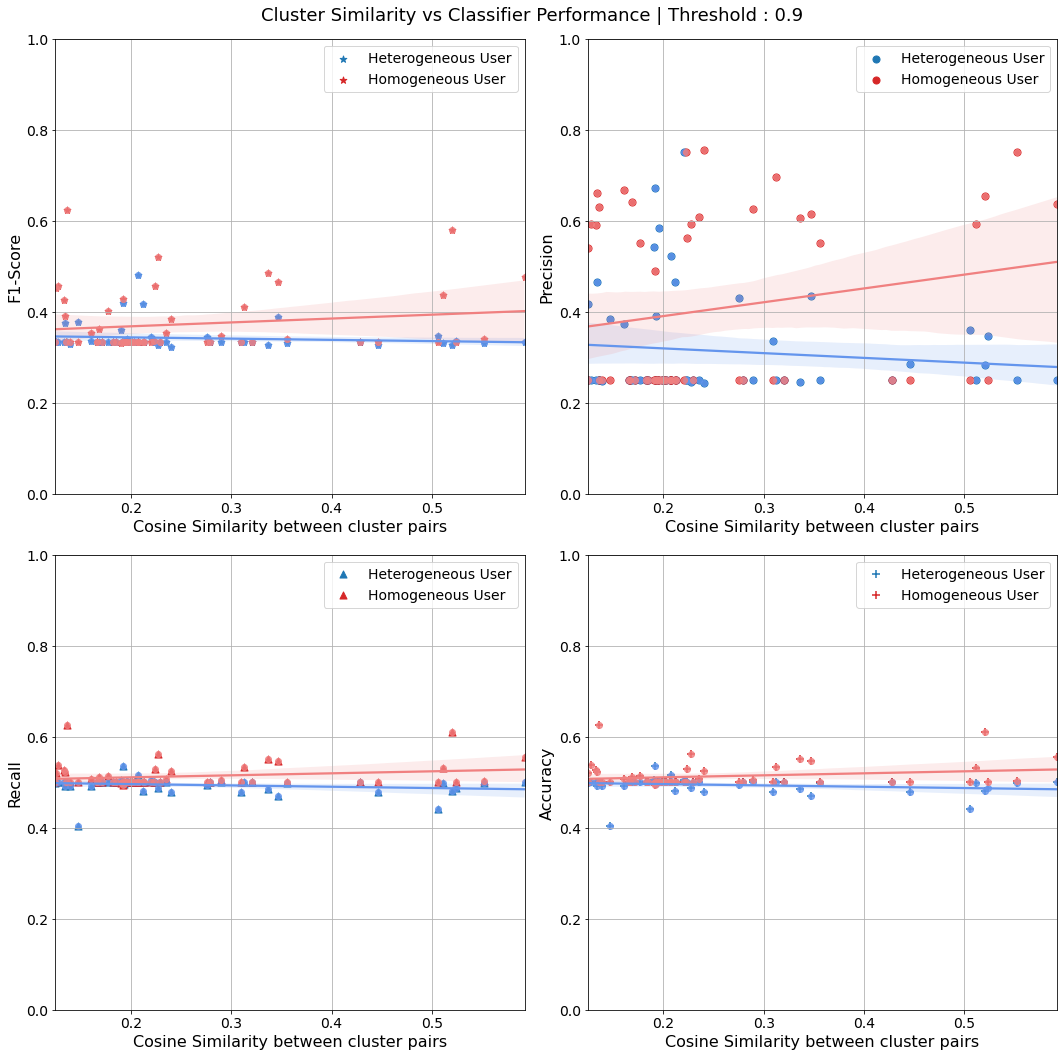


Finished running 'bsl1_sim_vs_score_all_users' in 0.0182 mins



In [13]:
for threshold in [0.5,0.7,0.9]:
    bsl1_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

<!-- ## Online Learning Setting - Active Learning Setting (Performance Measured on Held Out Validation Dataset) -->

## Baseline 2 : <a class="anchor" id="Online_Setting_Performance"></a>

In [14]:
hetero_scores,df_res_map_hetero = run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : (423, 437)
Training model for cluster pair : (338, 735)
Training model for cluster pair : (423, 498)
Training model for cluster pair : (437, 735)
Training model for cluster pair : (735, 942)
Training model for cluster pair : (423, 735)
Training model for cluster pair : (437, 942)
Training model for cluster pair : (423, 942)
Training model for cluster pair : (338, 423)
Training model for cluster pair : (338, 437)
Training model for cluster pair : (305, 338)
Training model for cluster pair : (338, 942)
Training model for cluster pair : (498, 735)
Training model for cluster pair : (70, 121)
Training model for cluster pair : (70, 187)
Training model for cluster pair : (305, 735)
Training model for cluster pair : (437, 498)
Training model for cluster pair : (338, 498)
Training model for cluster pair : (498, 942)
Training model for cluster pair : (70, 735)
Training model for cluster pair : (121, 187)
Training model for cluster pair : (121, 735)
Training mode

In [15]:
homo_scores, df_res_map_homo =  run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : (423, 437)
Training model for cluster pair : (338, 735)
Training model for cluster pair : (423, 498)
Training model for cluster pair : (437, 735)
Training model for cluster pair : (735, 942)
Training model for cluster pair : (423, 735)
Training model for cluster pair : (437, 942)
Training model for cluster pair : (423, 942)
Training model for cluster pair : (338, 423)
Training model for cluster pair : (338, 437)
Training model for cluster pair : (305, 338)
Training model for cluster pair : (338, 942)
Training model for cluster pair : (498, 735)
Training model for cluster pair : (70, 121)
Training model for cluster pair : (70, 187)
Training model for cluster pair : (305, 735)
Training model for cluster pair : (437, 498)
Training model for cluster pair : (338, 498)
Training model for cluster pair : (498, 942)
Training model for cluster pair : (70, 735)
Training model for cluster pair : (121, 187)
Training model for cluster pair : (121, 735)
Training mode


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



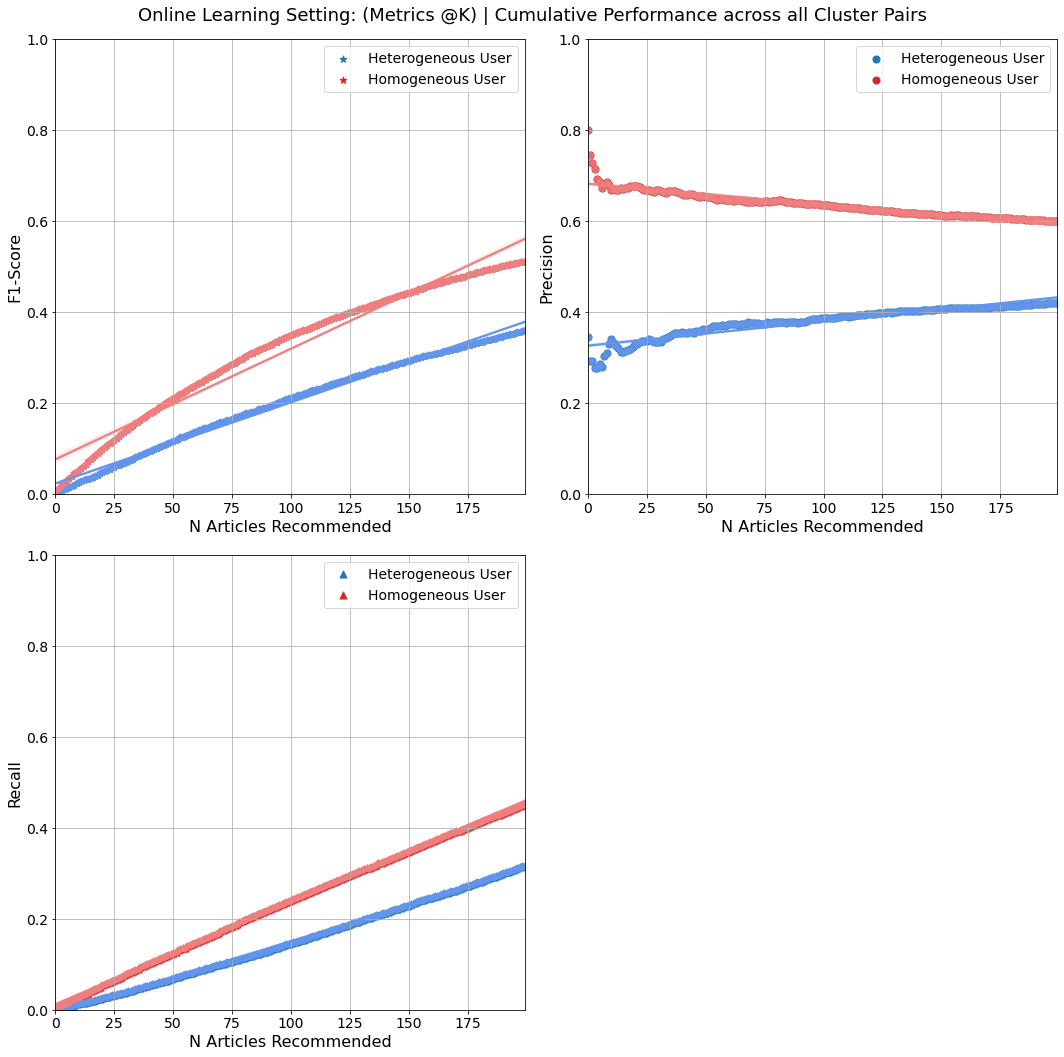


Finished running 'plot_online_setting_per_clusterpair' in 0.0186 mins


Finished running 'plot_online_learning_cumulative' in 0.0186 mins



In [16]:
plot_online_learning_cumulative(homo_scores,hetero_scores,active=False)

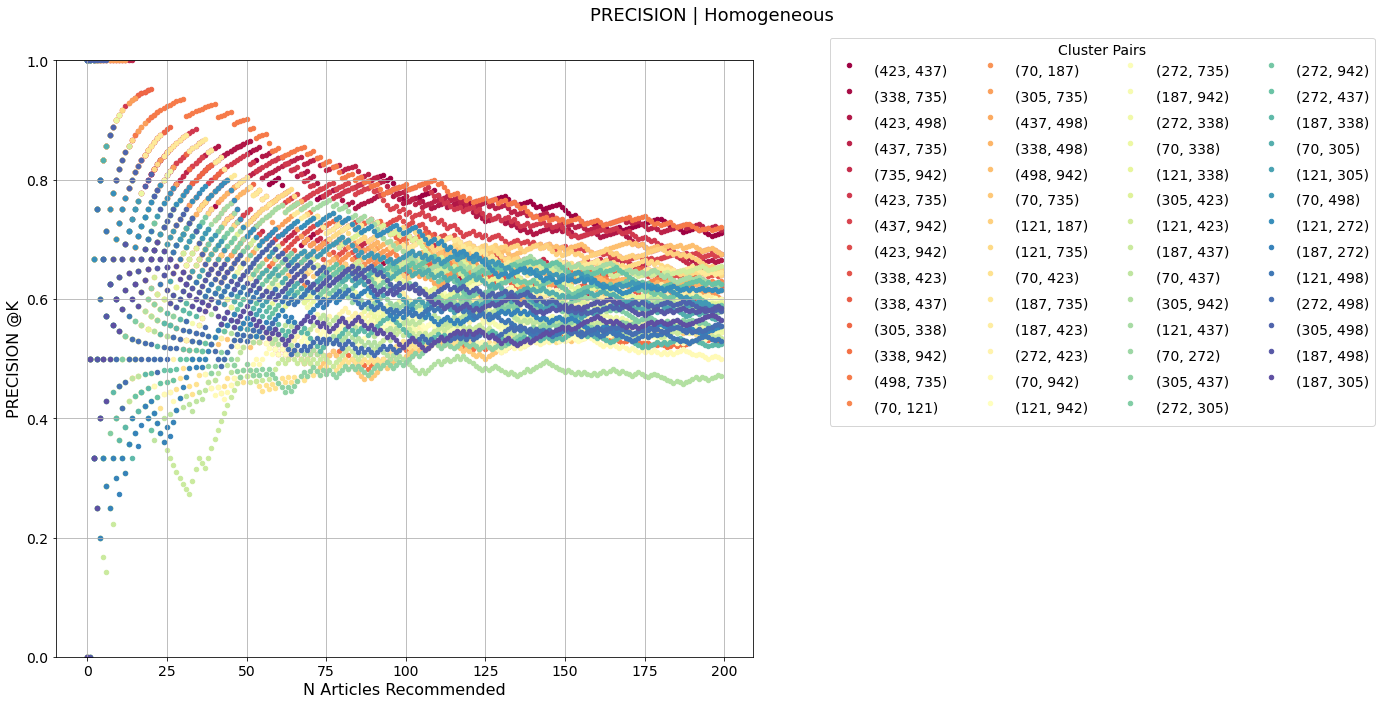


Finished running 'plot_all_cp_online' in 0.0371 mins



In [17]:
plot_all_cp_online(homo_scores,user_type="Homogeneous",metric="precision")

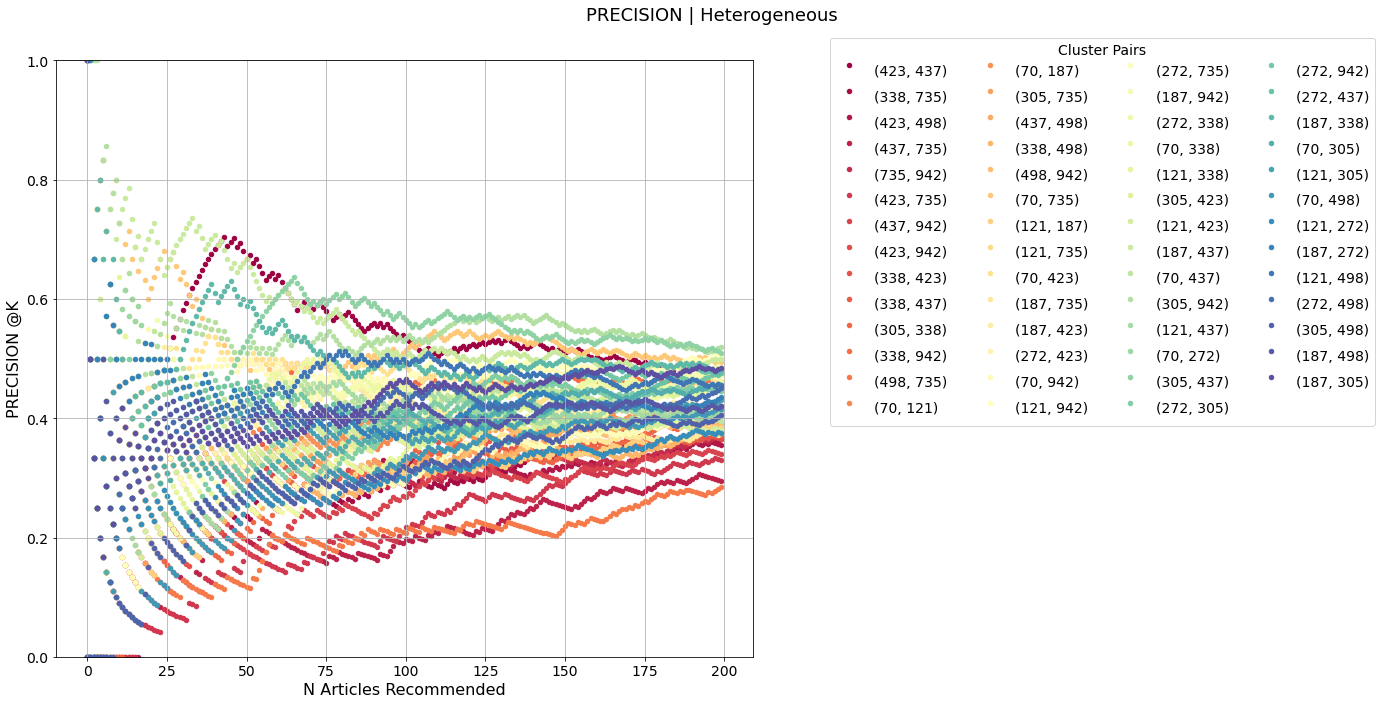


Finished running 'plot_all_cp_online' in 0.0357 mins



In [18]:
plot_all_cp_online(hetero_scores,user_type="Heterogeneous",metric="precision")

In [19]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [20]:
np.mean(avg_presc_homo)

0.6362480256429867

In [21]:
avg_presc_hetero = calculate_avg_precision(hetero_scores,mode="single")

In [22]:
np.mean(avg_presc_hetero)

0.37864310410994567

## Baseline 3 :  <a class="anchor" id="Single_Cluster_Online_Setting_Performance"></a>

In [23]:
hetero_scores = run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [24]:
homo_scores =  run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



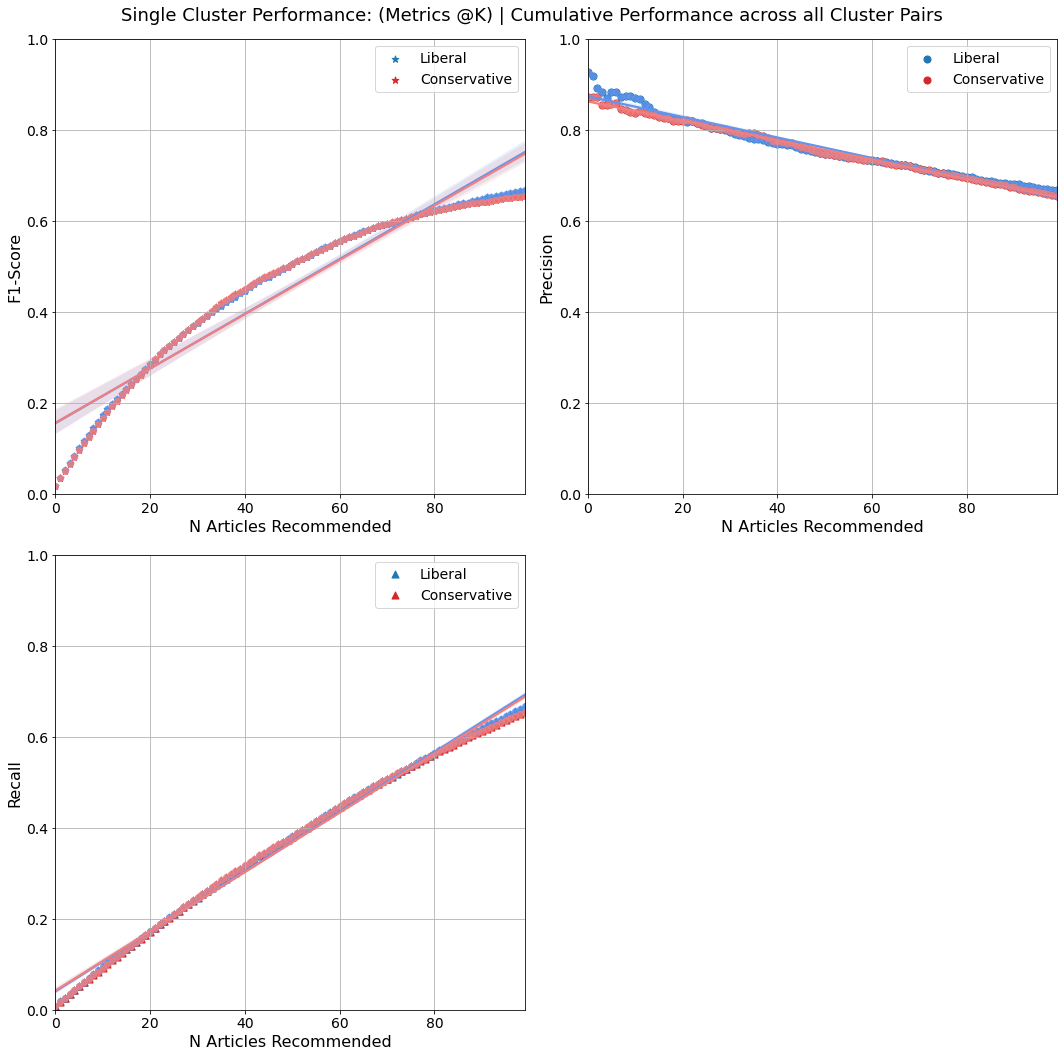


Finished running 'plot_single_cluster_performance' in 0.0158 mins


Finished running 'plot_single_cluster_cumulative' in 0.0159 mins



In [25]:
plot_single_cluster_cumulative(homo_scores,hetero_scores)

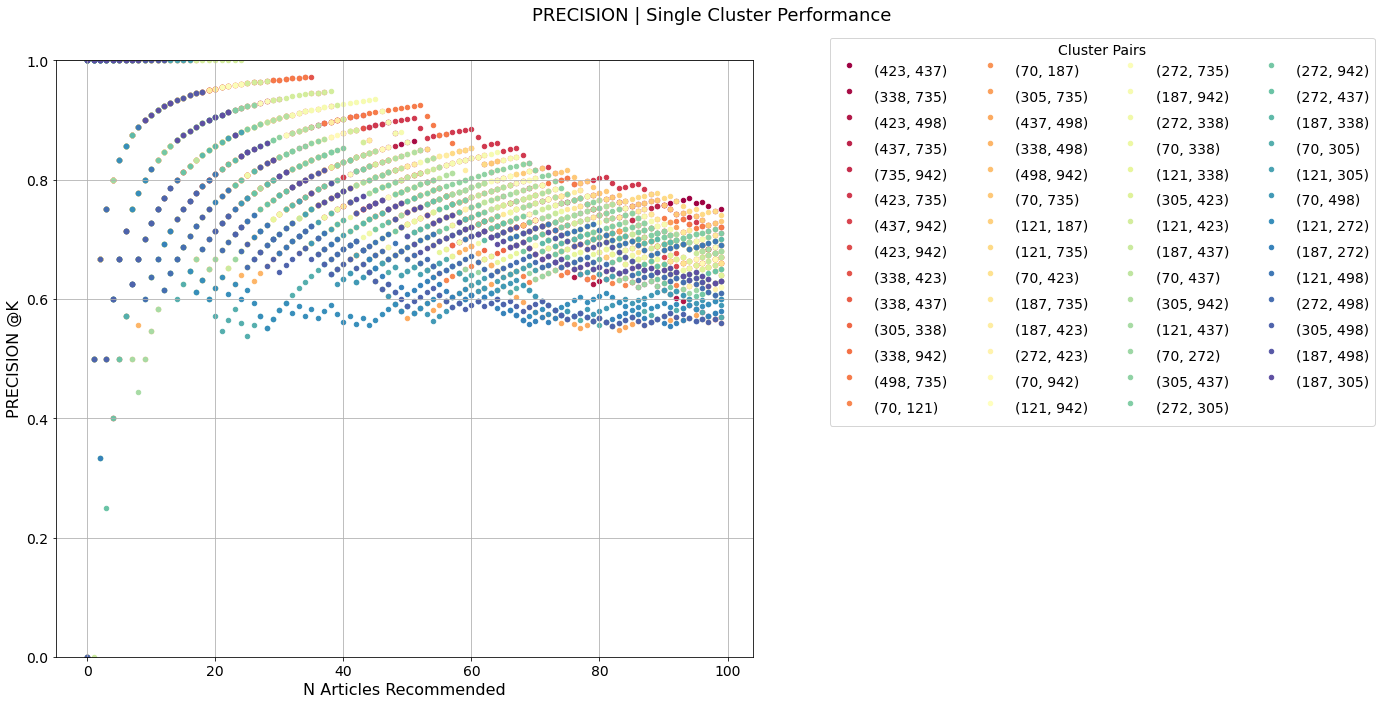


Finished running 'plot_all_cp_singlecluster' in 0.0333 mins



In [26]:
plot_all_cp_singlecluster(homo_scores)

In [27]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [28]:
np.mean(avg_presc_homo)

0.75692140068692

## Baseline 4: <a class="anchor" id="Regularization_vs_Online_Setting_Performance"></a>

In [29]:
hetero_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [30]:
homo_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0002 mins



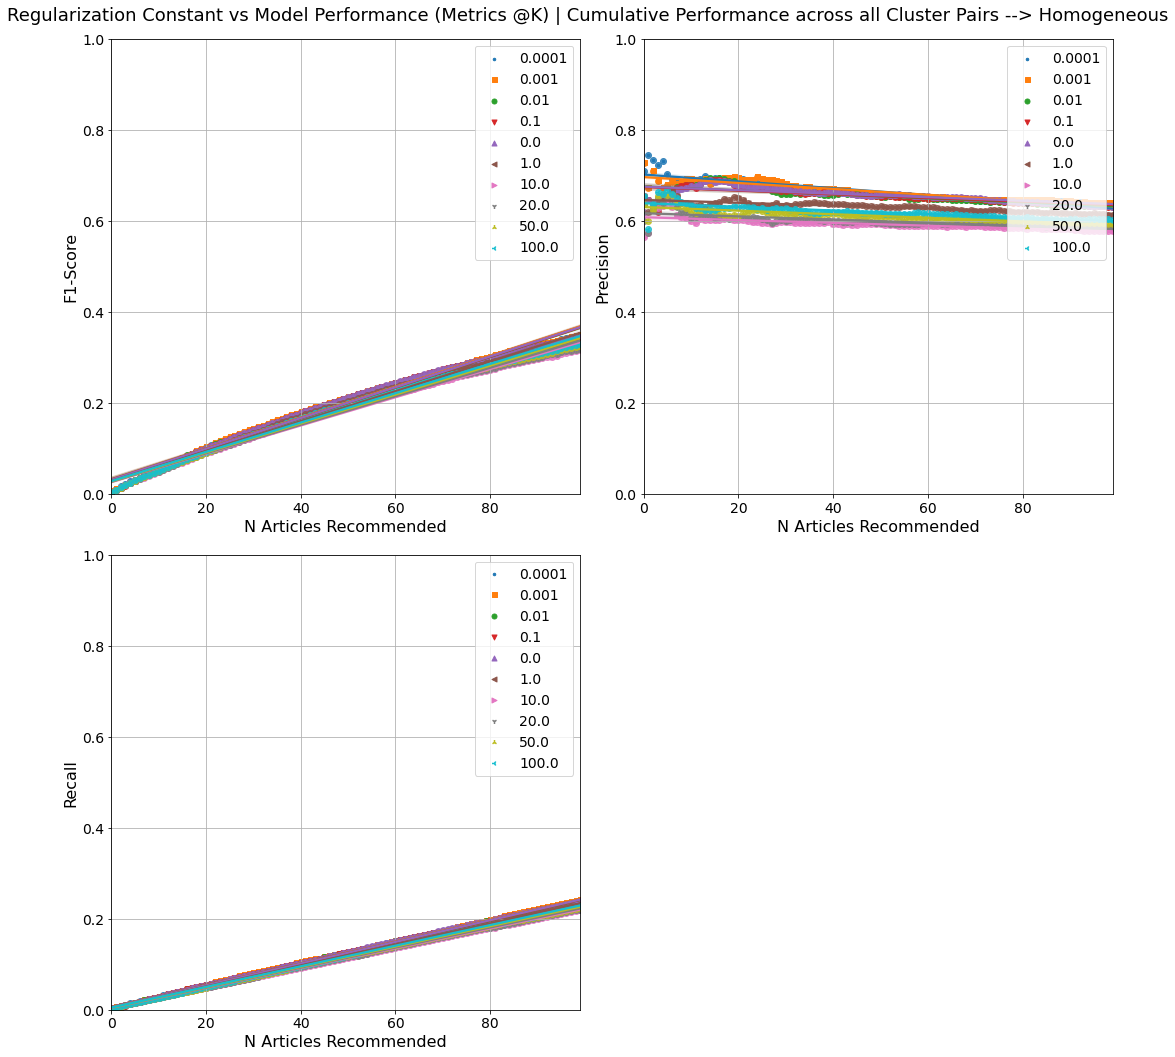


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0607 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0608 mins



In [31]:
plot_regularization_vs_metrics_at_k_cumu(homo_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0],
                                         user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0001 mins



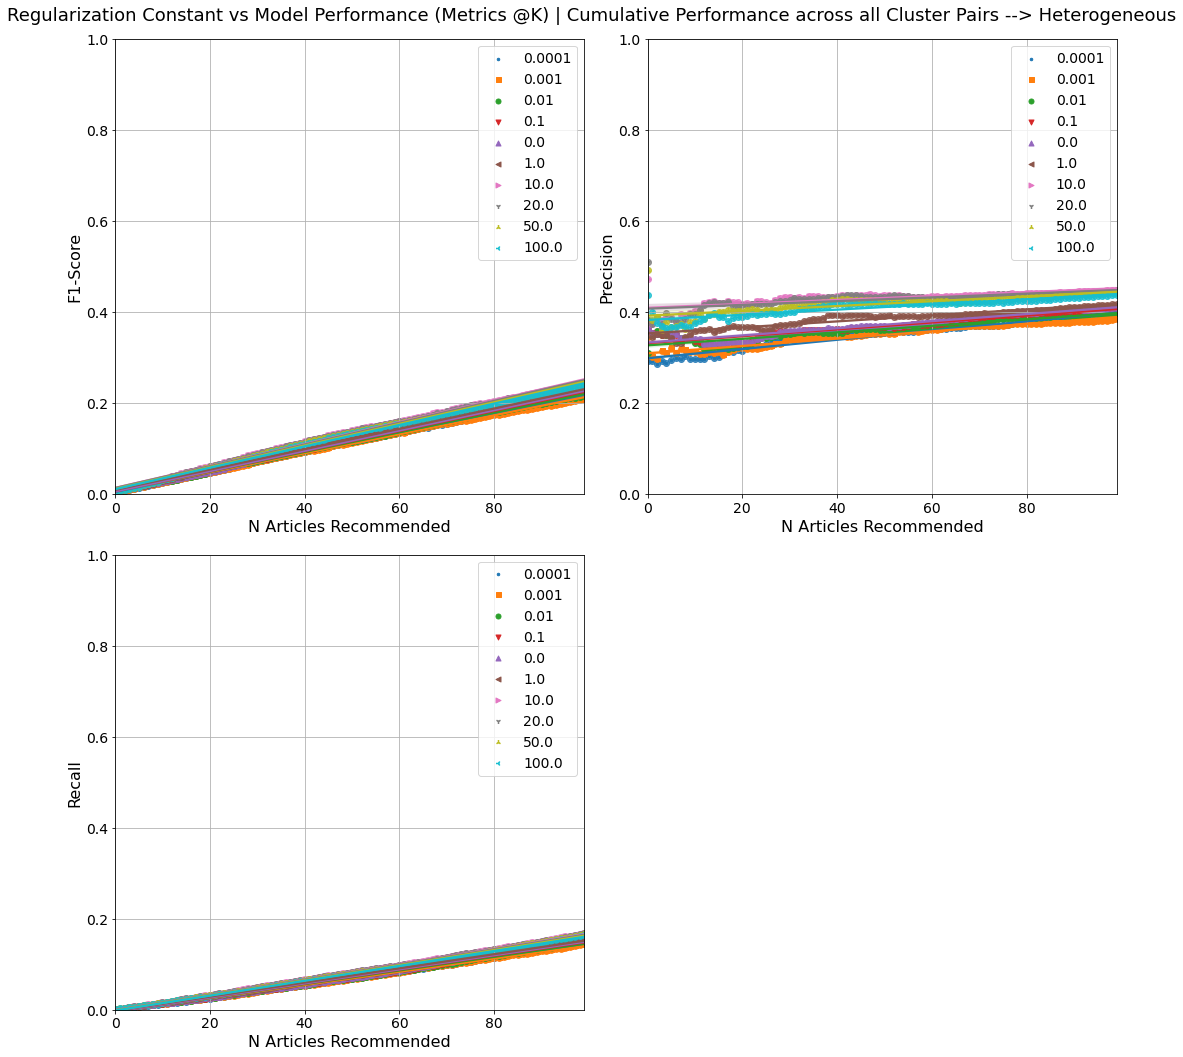


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0594 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0595 mins



In [32]:
plot_regularization_vs_metrics_at_k_cumu(hetero_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [33]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [34]:
calculate_map_param_variation(homo_param_res)


Param : 0.0001
0.6644679649471327

Param : 0.001
0.663869570189882

Param : 0.01
0.6538753977757347

Param : 0.1
0.6543275023724313

Param : 0.0
0.6557988578675128

Param : 1.0
0.6302877515456644

Param : 10.0
0.5923816062516204

Param : 20.0
0.5992894955030618

Param : 50.0
0.6106202885253137

Param : 100.0
0.618764573327245


In [35]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [36]:
calculate_map_param_variation(hetero_param_res)


Param : 0.0001
0.3481539090022081

Param : 0.001
0.3487262119280218

Param : 0.01
0.3617192878729522

Param : 0.1
0.3685827530204408

Param : 0.0
0.37123944406805476

Param : 1.0
0.38518920740346557

Param : 10.0
0.43022325850346566

Param : 20.0
0.4273926895560772

Param : 50.0
0.41771036034926745

Param : 100.0
0.41022186545391365


## Baseline 5 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Performance"></a>

In [37]:
hetero_scores,df_het_res_100,df_het_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (423, 437) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (423, 437) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (423, 437) , LR = 20 *****

In [38]:
homo_scores,df_hom_res_100,df_hom_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (423, 437) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (423, 437) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (423, 437) , LR = 20 *****


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0003 mins



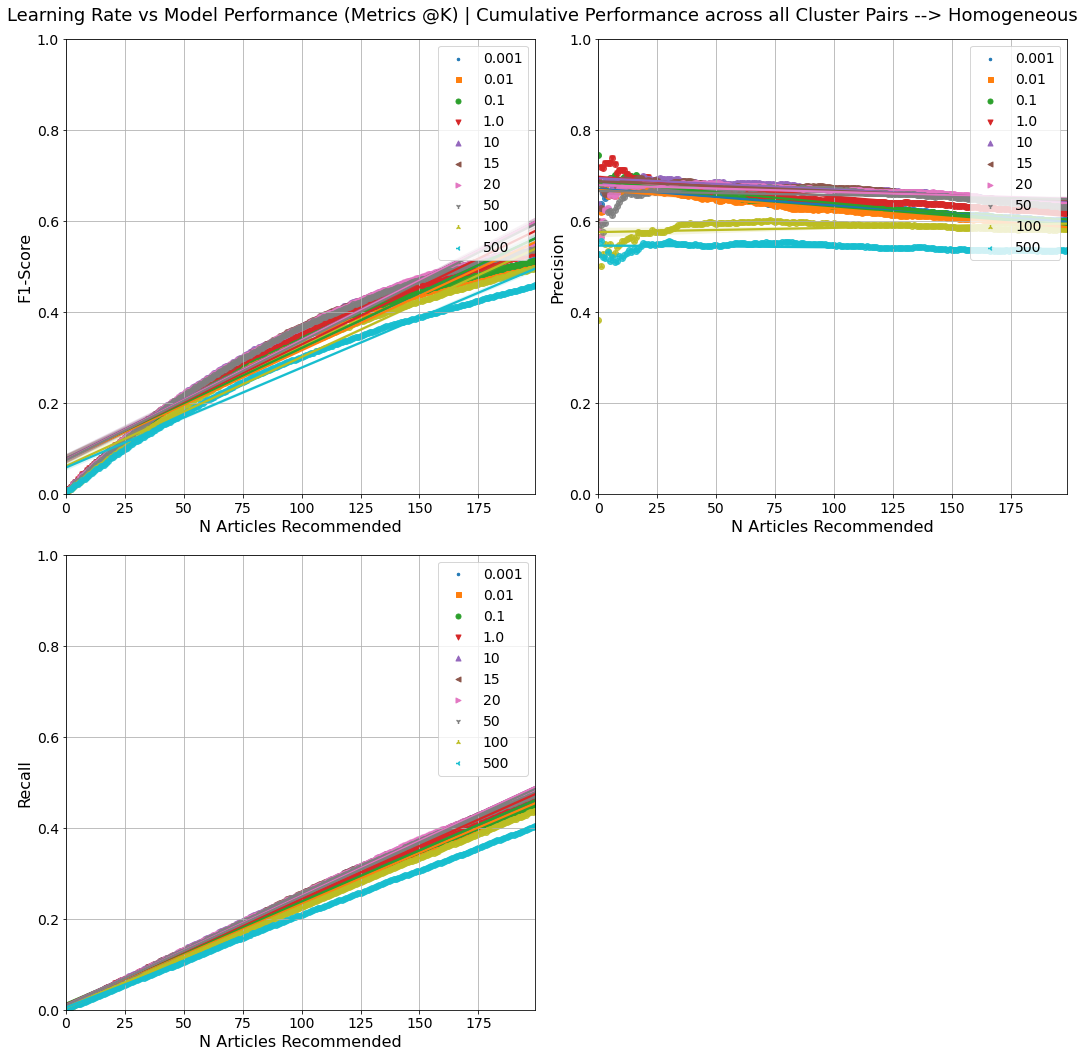


Finished running 'plot_lr_vs_metrics_at_k' in 0.0666 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0668 mins



In [39]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0004 mins



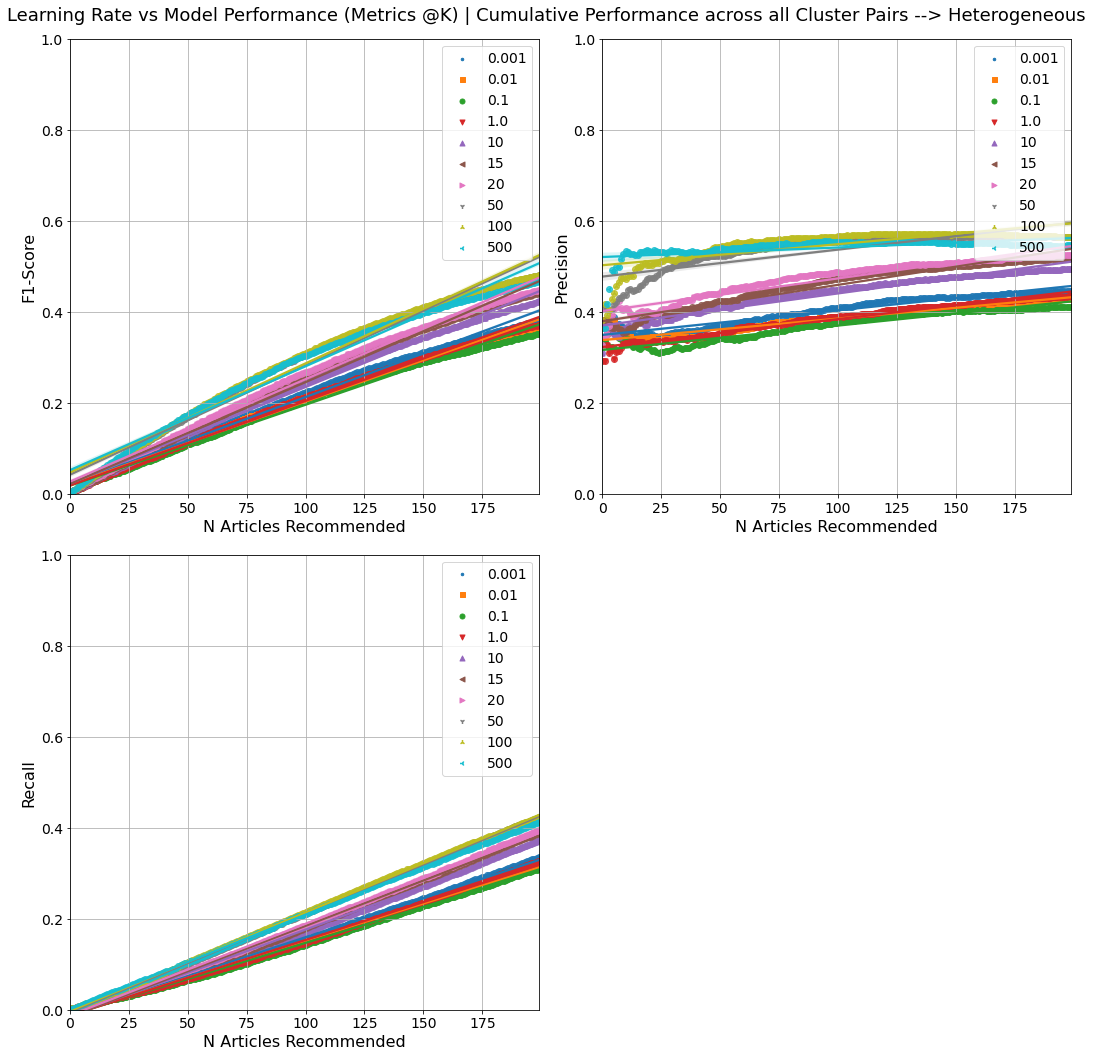


Finished running 'plot_lr_vs_metrics_at_k' in 0.0649 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0653 mins



In [40]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [41]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [42]:
calculate_map_param_variation(homo_param_res)


Param : 0.001
0.6340364594999909

Param : 0.01
0.626926973679264

Param : 0.1
0.6389617530840447

Param : 1.0
0.6534315105004991

Param : 10
0.6685786010814921

Param : 15
0.6659515461562517

Param : 20
0.6633603567836812

Param : 50
0.6565459242904739

Param : 100
0.5844005777598099

Param : 500
0.5417128405253616


In [43]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [44]:
calculate_map_param_variation(hetero_param_res)


Param : 0.001
0.40296487751963195

Param : 0.01
0.38498158891207607

Param : 0.1
0.36945142127071184

Param : 1.0
0.3836513979236783

Param : 10
0.44001492758887045

Param : 15
0.4587829934549051

Param : 20
0.4730481255799564

Param : 50
0.5363407072305997

Param : 100
0.5483292811096915

Param : 500
0.5411963249291762


## Baseline 6: <a class="anchor" id="Online_Setting_Mixed_Data_Performance"></a>

In [72]:
hetero_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [73]:
homo_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [74]:
# homo_scores.keys()

In [75]:
# plot_mixed_data_performance_per_cluster(homo_scores[(585, 712)],hetero_scores[(585, 712)])


Finished running 'combine_scores_mixed_data' in 0.0001 mins


Finished running 'combine_scores_mixed_data' in 0.0001 mins



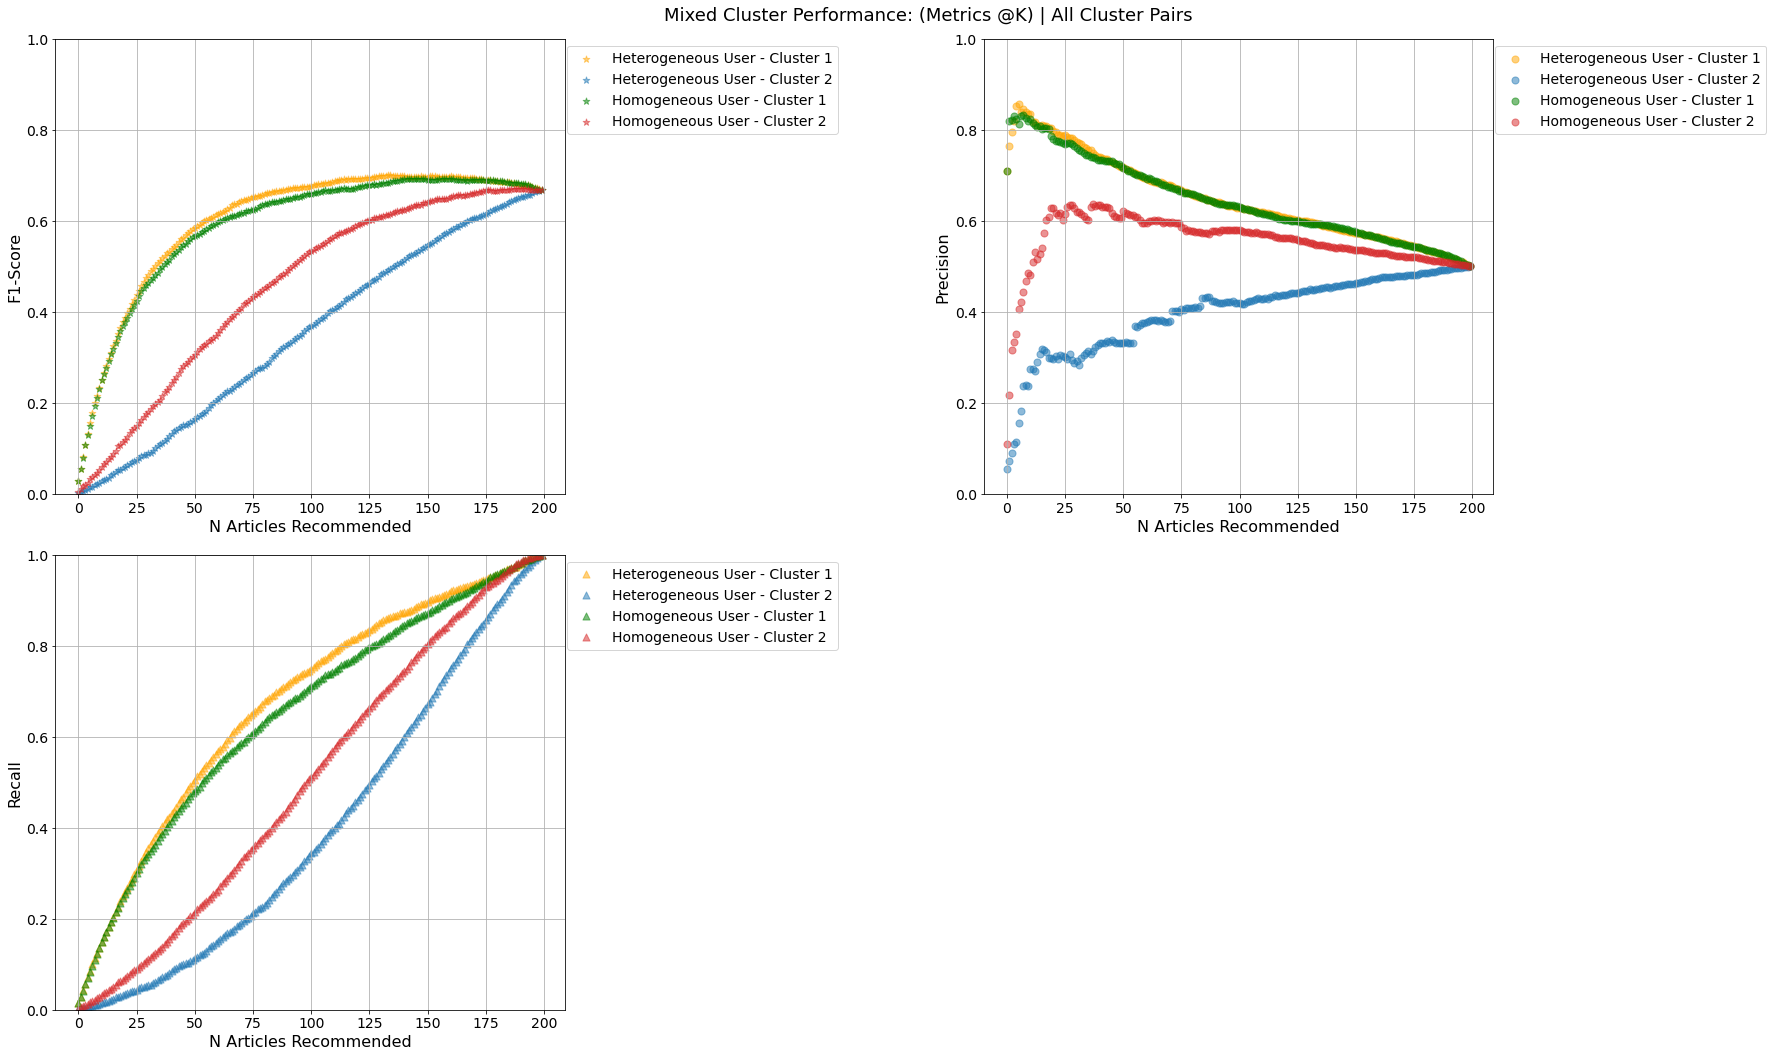


Finished running 'plot_mixed_data_performance_per_cluster' in 0.0126 mins


Finished running 'plot_mixed_cluster_cumulative_per_cluster' in 0.0128 mins



In [76]:
plot_mixed_cluster_cumulative_per_cluster(homo_scores,hetero_scores)

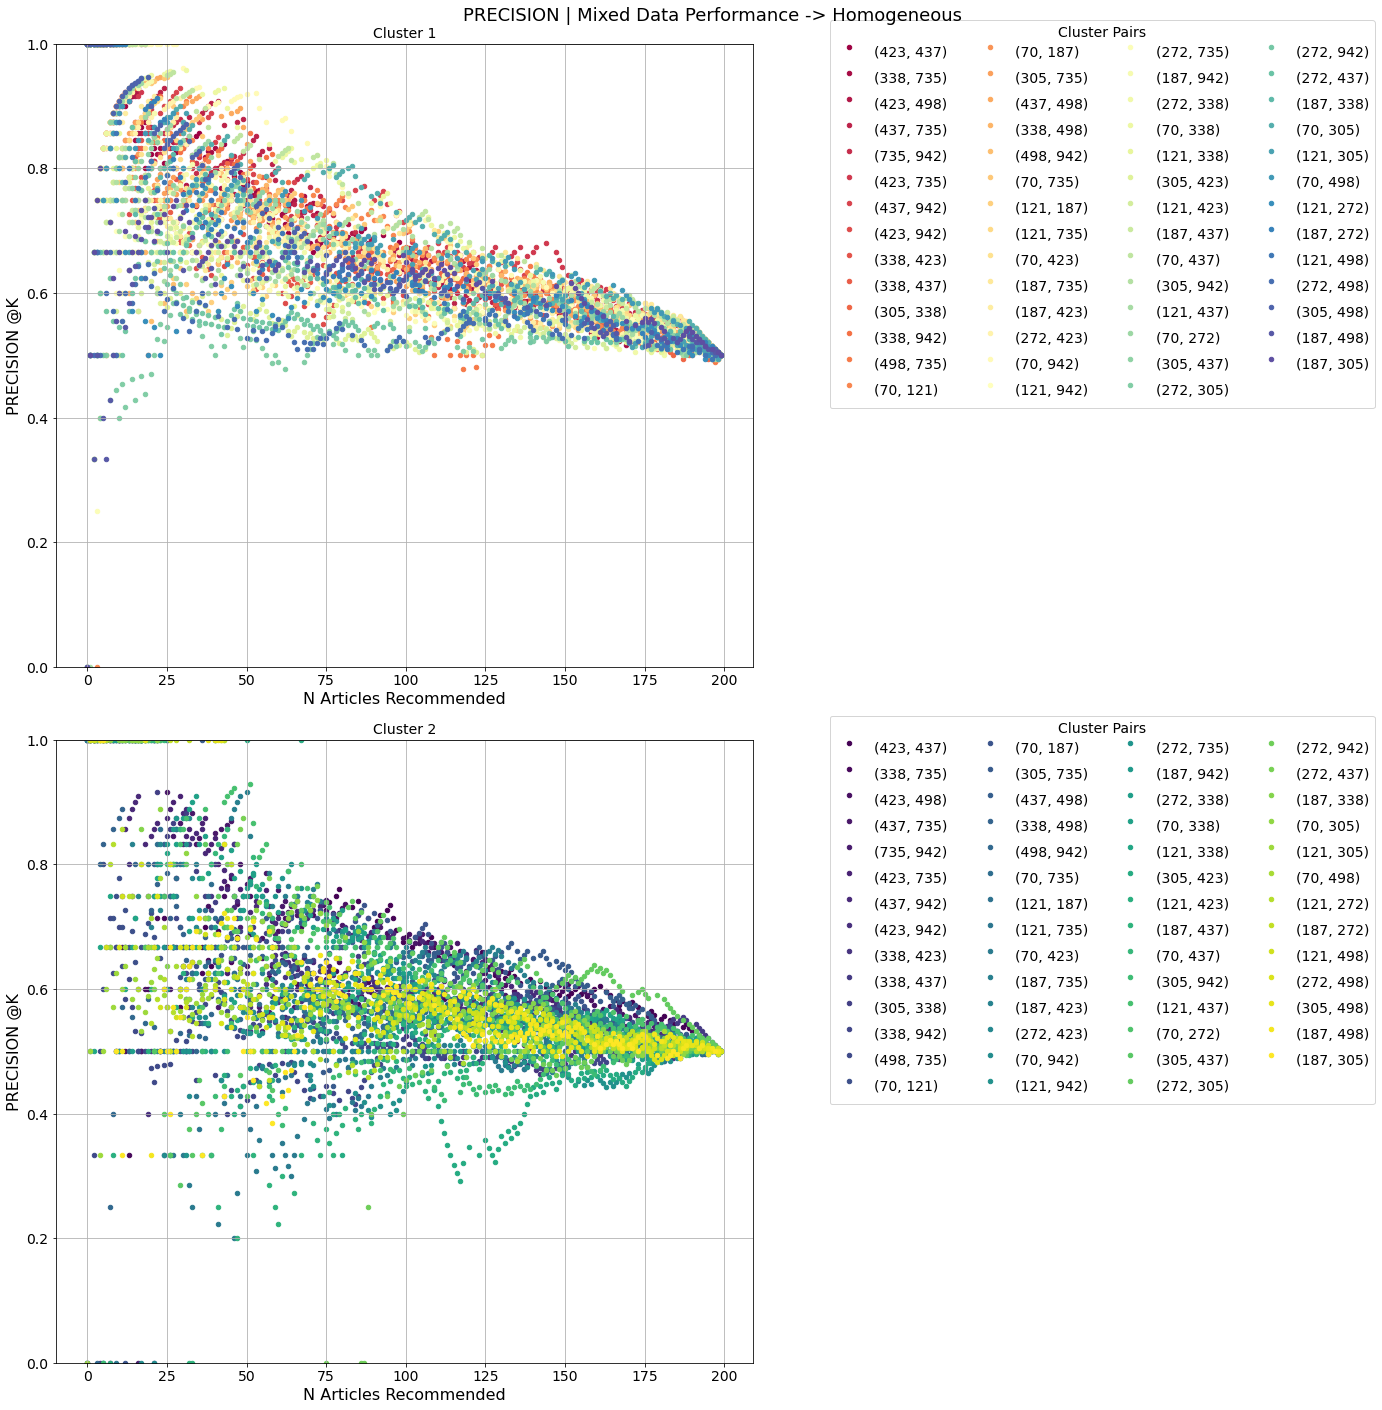


Finished running 'plot_mixed_data_all_cp_perf' in 0.0685 mins



In [77]:
plot_mixed_data_all_cp_perf(scores_cp=homo_scores,user_type="Homogeneous",metric="precision")

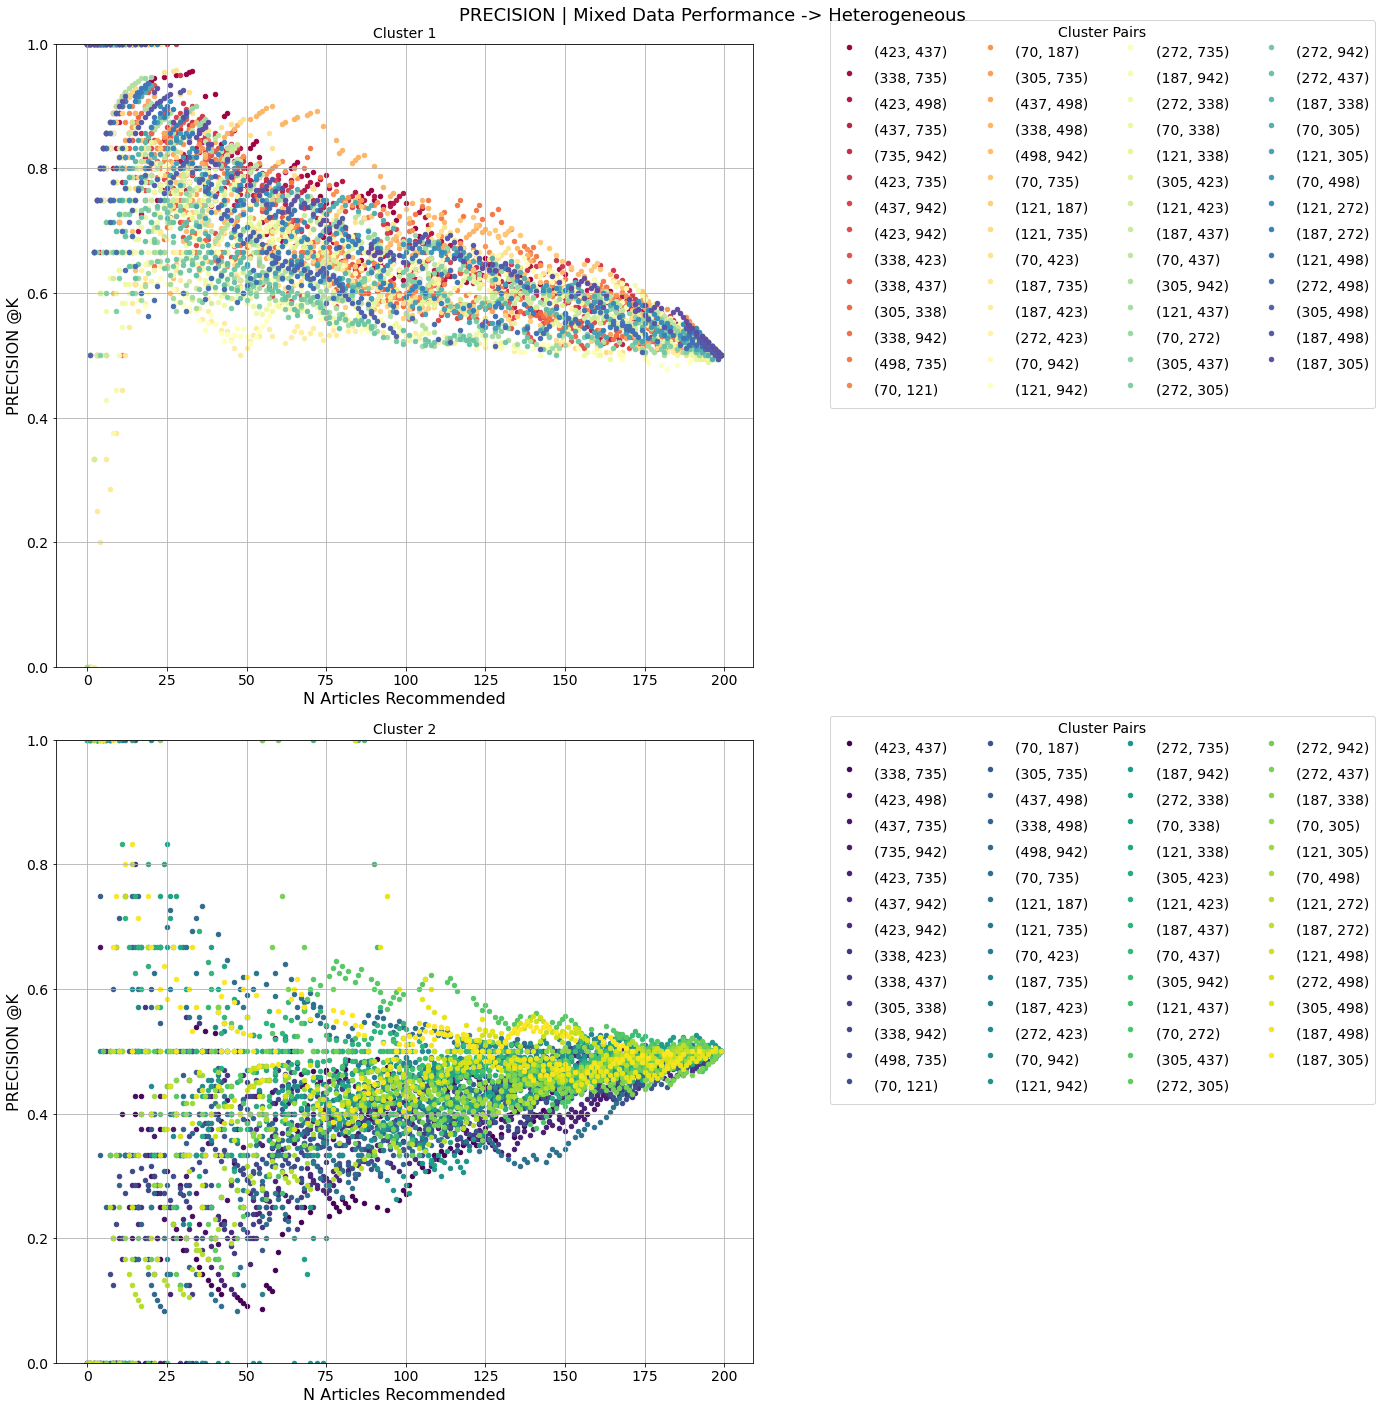


Finished running 'plot_mixed_data_all_cp_perf' in 0.0677 mins



In [78]:
plot_mixed_data_all_cp_perf(scores_cp=hetero_scores,user_type="Heterogeneous",metric="precision")

In [90]:
avg_presc_homo, avg_presc_homo_c1, avg_presc_homo_c2 = calculate_avg_precision(homo_scores,mode="mixed")

In [91]:
np.mean(avg_presc_homo)

0.6264413994995456

In [92]:
np.mean(avg_presc_homo_c1)

0.64607254257748

In [94]:
# avg_presc_homo_c2

In [95]:
np.mean(avg_presc_homo_c2)

0.5549657055481654

In [96]:
avg_presc_hetero,avg_presc_hetero_c1, avg_presc_hetero_c2 = calculate_avg_precision(hetero_scores,mode="mixed")

In [97]:
np.mean(avg_presc_hetero)

0.5744329230166975

In [98]:
np.mean(avg_presc_hetero_c1)

0.6483253846345035

In [99]:
np.mean(avg_presc_hetero_c2)

0.399117559509623

## Baseline 7 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Mixed_Data_Performance"></a>

In [100]:
hetero_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [101]:
homo_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [102]:
# plot_lr_vs_metrics_at_k_mixed(homo_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],user_type="Homogeneous")

In [103]:
# plot_lr_vs_metrics_at_k_mixed(hetero_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0003 mins



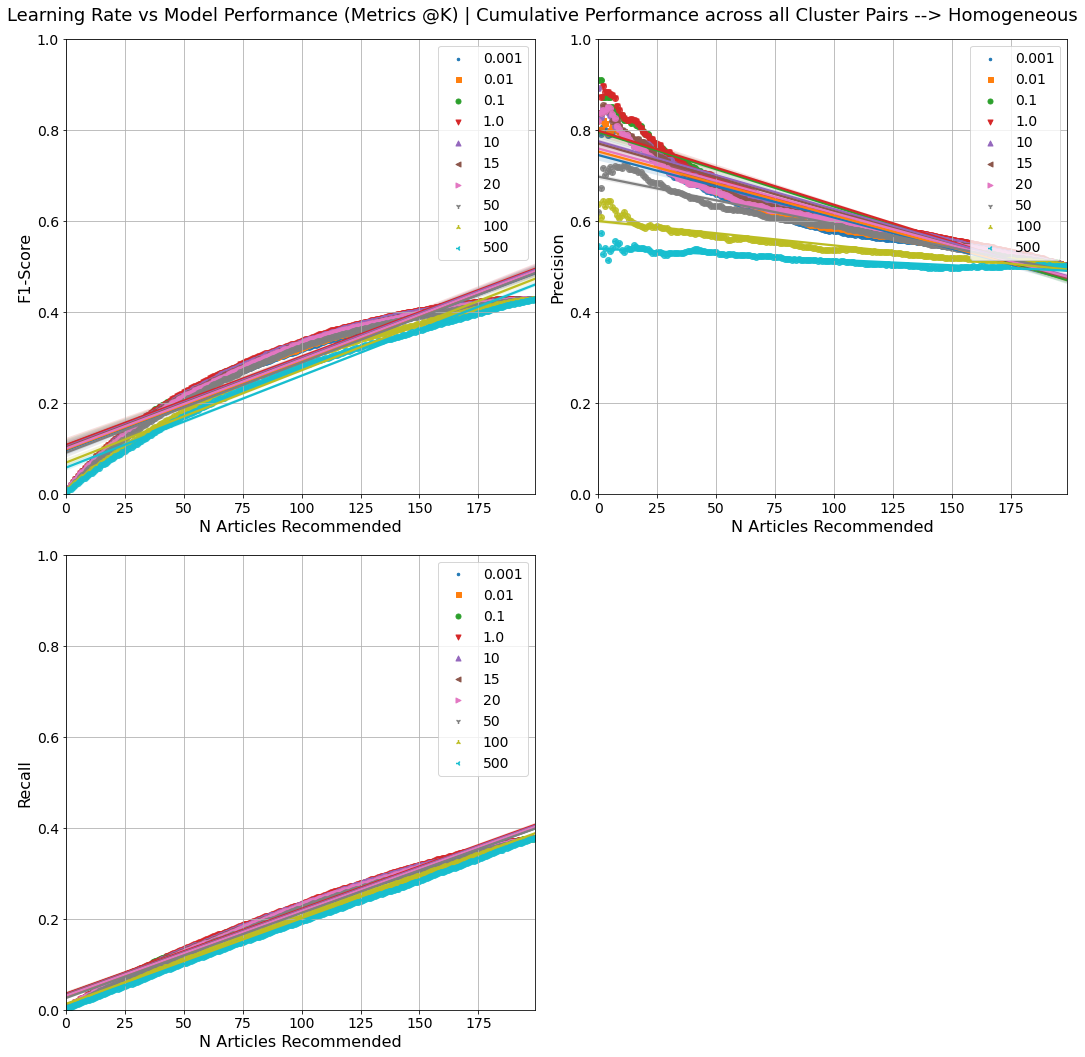


Finished running 'plot_lr_vs_metrics_at_k' in 0.0668 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0672 mins



In [104]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous",mixed_data=True)


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0003 mins



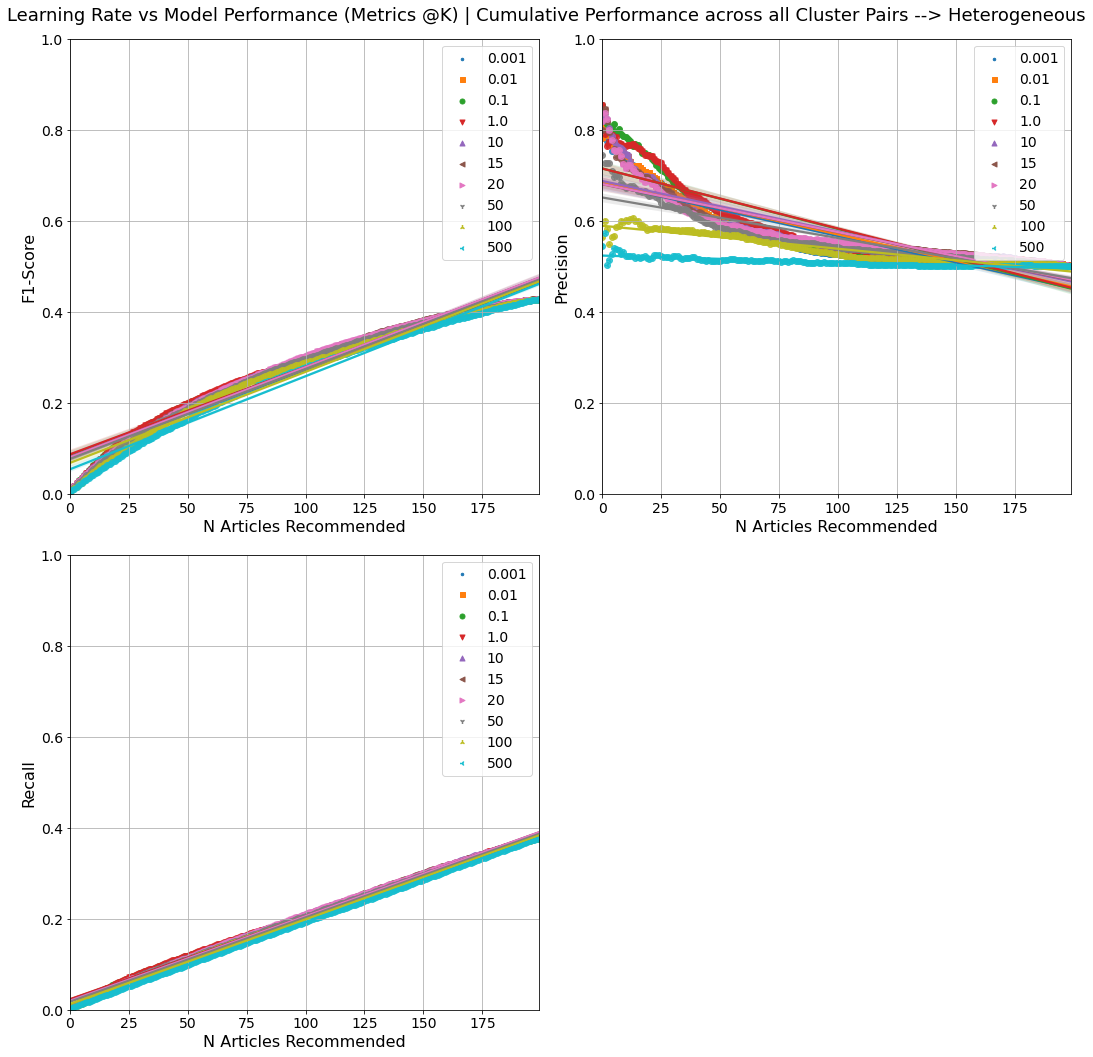


Finished running 'plot_lr_vs_metrics_at_k' in 0.0659 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0662 mins



In [105]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mixed_data=True)

In [106]:
#  plot_mixed_data_all_cp_precis_lr(scores_=homo_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Homogeneous",metric="precision")

In [107]:
#  plot_mixed_data_all_cp_precis_lr(scores_=hetero_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Heterogeneous",metric="precision")

In [108]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [109]:
calculate_map_param_variation(homo_param_res,mode="mixed")


Param : 0.001
0.607780499086429
c1 MAP : 
0.6150974596498765
c2 MAP : 
0.4605980277804747

Param : 0.01
0.6122304702315793
c1 MAP : 
0.6260302719782651
c2 MAP : 
0.48086557533971375

Param : 0.1
0.6321625345254238
c1 MAP : 
0.6556815105894584
c2 MAP : 
0.5394557237081302

Param : 1.0
0.6359548402848808
c1 MAP : 
0.657977381840006
c2 MAP : 
0.5502210612721593

Param : 10
0.6264714320900324
c1 MAP : 
0.65875619882596
c2 MAP : 
0.5286940227236986

Param : 15
0.6219097309145272
c1 MAP : 
0.6523785589151575
c2 MAP : 
0.5327682063765228

Param : 20
0.6178595776866367
c1 MAP : 
0.6486660857201638
c2 MAP : 
0.5231439940832445

Param : 50
0.5934397014137077
c1 MAP : 
0.611776227930173
c2 MAP : 
0.5021975711070202

Param : 100
0.5460939403168669
c1 MAP : 
0.5448182525163284
c2 MAP : 
0.4865276470117324

Param : 500
0.5145094866158597
c1 MAP : 
0.5105304770034284
c2 MAP : 
0.4852875106714149


In [110]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [111]:
calculate_map_param_variation(hetero_param_res,mode="mixed")


Param : 0.001
0.5669272572146317
c1 MAP : 
0.6198475713108028
c2 MAP : 
0.3392180837628279

Param : 0.01
0.570477420888724
c1 MAP : 
0.6328922275233109
c2 MAP : 
0.3532371755408063

Param : 0.1
0.5827805903758361
c1 MAP : 
0.6561796187768547
c2 MAP : 
0.368697523431847

Param : 1.0
0.5837338696097712
c1 MAP : 
0.6512664590628627
c2 MAP : 
0.3730537943284335

Param : 10
0.5769258363494995
c1 MAP : 
0.6485963539401308
c2 MAP : 
0.40059852776194904

Param : 15
0.5749130535951317
c1 MAP : 
0.6436535677131578
c2 MAP : 
0.39988135994367763

Param : 20
0.5756122449792311
c1 MAP : 
0.6469962493037426
c2 MAP : 
0.40947781503869457

Param : 50
0.5625138494984996
c1 MAP : 
0.6061905313136894
c2 MAP : 
0.4296302580592726

Param : 100
0.5387859293900652
c1 MAP : 
0.5489551623784806
c2 MAP : 
0.4454340648656893

Param : 500
0.5093479643271228
c1 MAP : 
0.5115720256215297
c2 MAP : 
0.48003313440200623
